# I am working with the Titanic data from Kaggle to learn more R and to learn using the Caret package

In [1]:
library(dplyr)
library(caret)
library(ggplot2)
library(repr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2


In [2]:
setPlotDim <- function(height = 3, width = 3) {
    ## Function for controlling the plot dimensions
    options(repr.plot.height = height,repr.plot.width = width)
}

In [3]:
# Read in the data
dat.train <- read.csv('data/train.csv', stringsAsFactors=FALSE)
dat.test <- read.csv('data/test.csv', stringsAsFactors=FALSE)

# Info about survival in test set
survived.test <- read.csv('data/gender_submission.csv', stringsAsFactors=FALSE)

In [4]:
# Datasets do not have similar cols
print(dim(dat.train))
print(dim(dat.test))

[1] 891  12
[1] 418  11


In [5]:
# Which columns does not exist in test data
names(dat.train)[is.na(match(names(dat.train), names(dat.test)))]

[1] "Survived"

In [6]:
str(survived.test)

'data.frame':	418 obs. of  2 variables:
 $ PassengerId: int  892 893 894 895 896 897 898 899 900 901 ...
 $ Survived   : int  0 1 0 0 1 0 1 0 1 0 ...


In [7]:
# Merge the two dataframes such that survival is present
dat.test <- merge(dat.test, survived.test, by='PassengerId')

In [8]:
# Append the two datasets
dat <- rbind(dat.train, dat.test)

In [9]:
str(dat)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [10]:
# Use only some columns
dat <- dat[, c('Pclass','Age', 'Sex', 'Fare', 'Embarked', 'Survived')]

In [11]:
head(dat)

Pclass,Age,Sex,Fare,Embarked,Survived
3,22,male,7.2500,S,0
1,38,female,71.2833,C,1
3,26,female,7.9250,S,1
1,35,female,53.1000,S,1
3,35,male,8.0500,S,0
3,NA,male,8.4583,Q,0


In [12]:
# Change datatypes
change.dattypes <- function(df) {
    df$Pclass <- factor(df$Pclass, levels = 1:3)
    df$Age <- as.numeric(df$Age)
    df$Sex <- factor(df$Sex)
    df$Fare <- as.numeric(df$Fare)
    df$Embarked <- factor(df$Embarked)
    df$Survived <- factor(df$Survived)
    return(df)
}

In [13]:
dat <- change.dattypes(dat)
summary(dat)

 Pclass       Age            Sex           Fare         Embarked Survived
 1:323   Min.   : 0.17   female:466   Min.   :  0.000    :  2    0:815   
 2:277   1st Qu.:21.00   male  :843   1st Qu.:  7.896   C:270    1:494   
 3:709   Median :28.00                Median : 14.454   Q:123            
         Mean   :29.88                Mean   : 33.295   S:914            
         3rd Qu.:39.00                3rd Qu.: 31.275                    
         Max.   :80.00                Max.   :512.329                    
         NA's   :263                  NA's   :1                          

In [14]:
str(dat)

'data.frame':	1309 obs. of  6 variables:
 $ Pclass  : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Age     : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...
 $ Survived: Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...


In [15]:
# Find the NA values
sapply(dat, function(x) sum(is.na(x)))

Pclass      Age      Sex     Fare Embarked Survived 
       0      263        0        1        0        0

In [16]:
imputeMissingValues <- function(df, colname, func) {
    # Works with median and mean (this is tested).
    if (is.numeric(df[, colname])) {
        df[is.na(df[, colname]), colname] <- func(df[, colname], na.rm = TRUE)
    }
    return(df)
}
# Input median for the missing ages and fares
dat <- imputeMissingValues(dat, 'Age', func = median)
dat <- imputeMissingValues(dat, 'Fare', func = median)

In [17]:
# Print the change in Age stats. Just small changes due to imputation
summary(dat$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.17   22.00   28.00   29.50   35.00   80.00 

In [18]:
summary(dat$Fare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   7.896  14.450  33.280  31.280 512.300 

In [19]:
# Find the NA values
sapply(dat, function(x) sum(is.na(x)))

Pclass      Age      Sex     Fare Embarked Survived 
       0        0        0        0        0        0

In [20]:
# Take a look at the unique values of some of the char. datatypes
lapply(dat.train[, c('Pclass', 'Sex', 'Embarked')], unique)

$Pclass
[1] 3 1 2

$Sex
[1] "male"   "female"

$Embarked
[1] "S" "C" "Q" ""

In [21]:
# How many rows are empty 
table(dat$Embarked)


      C   Q   S 
  2 270 123 914 

In [22]:
# Let us remove the two rows containing ""
dat <- filter(dat, Embarked != "")
dat$Embarked <- droplevels(dat$Embarked) # Drop unused levels

In [23]:
# How many rows are empty 
table(dat$Embarked)


  C   Q   S 
270 123 914 

# Some plotting


In [24]:
setPlotDim(3, 4)

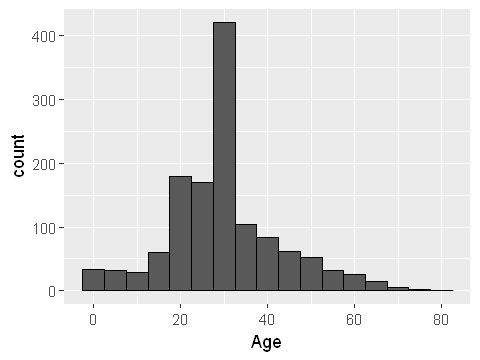

In [25]:
ggplot(dat, aes(Age)) + geom_histogram(col='black', binwidth = 5)

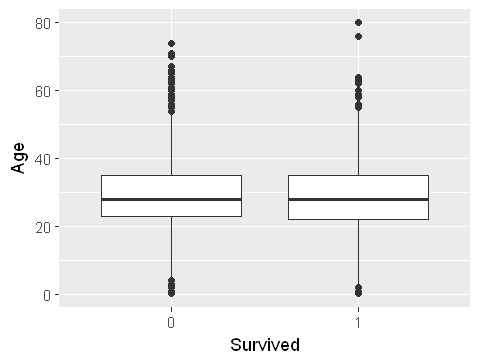

In [26]:
ggplot(dat, aes(Survived, Age)) + geom_boxplot()

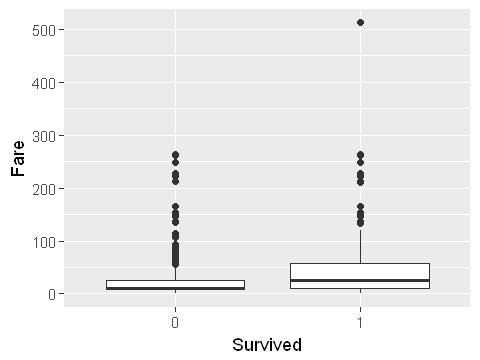

In [27]:
ggplot(dat, aes(Survived, Fare)) + geom_boxplot()

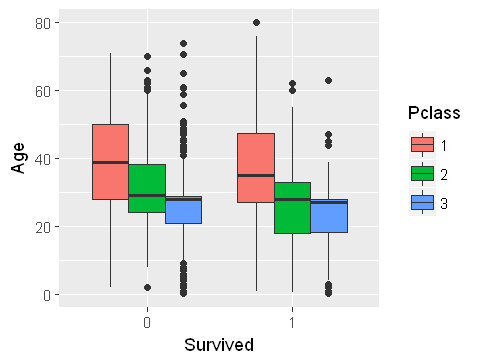

In [28]:
ggplot(dat, aes(Survived, Age)) + geom_boxplot(aes(fill = Pclass))

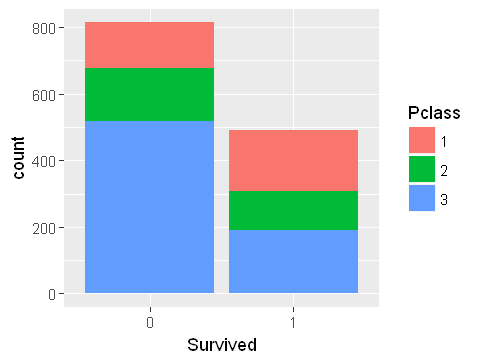

In [29]:
ggplot(dat, aes(Survived)) + geom_bar(aes(fill = Pclass))

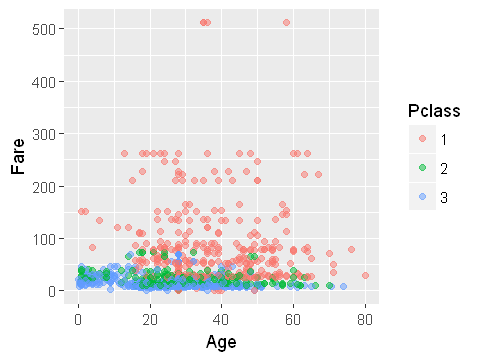

In [30]:
ggplot(dat, aes(x = Age, y = Fare, color = Pclass)) + geom_point(alpha=0.5)

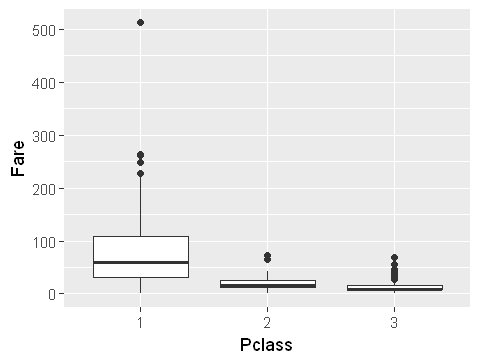

In [31]:
ggplot(dat, aes(x=Pclass, y=Fare)) + geom_boxplot()

# Machine learning


In [32]:
# Most people died
prop.table(table(dat$Survived))


        0         1 
0.6235654 0.3764346 

## Normalize numerical data

In [33]:
# Normalize the numerical values. Subtract mean, and divide with sd
normPreProc <- preProcess(dat, method = c('center', 'scale'))

# Transform the data
dat <- predict(normPreProc, dat)
summary(dat) # Check if ok

 Pclass       Age              Sex           Fare          Embarked Survived
 1:321   Min.   :-2.2747   female:464   Min.   :-0.64175   C:270    0:815   
 2:277   1st Qu.:-0.5800   male  :843   1st Qu.:-0.48917   Q:123    1:492   
 3:709   Median :-0.1143                Median :-0.36243   S:914            
         Mean   : 0.0000                Mean   : 0.00000                    
         3rd Qu.: 0.4292                3rd Qu.:-0.03738                    
         Max.   : 3.9225                Max.   : 9.25857                    

## Set up training features and labels

In [34]:
getFeaturesLabels <- function(dat, label) {
    ## Function which extracts features and labels from
    ## dataset and returns them as a matrix and vector
    ## respectively.
    
    # Break if label is not found
    if (!TRUE %in% grepl(label, colnames(dat))) { 
        stop('Label not found in colnames: ', label)       
        }
    
    X <- dat[, !(colnames(dat) %in% label)] # Feature matrix
    y <- dat[, label] # Label vector
    
    return(list(features = X, labels = y))
}       

In [35]:
# Split into features and label
mldata <- getFeaturesLabels(dat, label = 'Survived')

y <- mldata$labels # Labels
X <- mldata$features # Feature matrix

## Split data 70/30

In [36]:
# Split data into test and train
set.seed(123)
split <- createDataPartition(y, p = 0.7, list = FALSE)

# Training sets
X.train <- X[split, ]
y.train <- y[split]

# Testing sets
X.test <- X[-split, ]
y.test <- y[-split]

In [37]:
print(dim(X.test))
print(length(y.test))

[1] 391   5
[1] 391


## Package for ROC curves

In [38]:
library(ROCR)

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



In [39]:
plotRoc <- function(pred, title.text = '', width = 3, height = 3) {
    ## Function to plot the ROC curve together with the AUC value
    
    require(ROCR)
    
    # Calculate the False and True Positve rate
    perf <- performance(pred, measure = 'tpr', x.measure = 'fpr')
    
    # Get the AUC value
    auc.tmp <- performance(pred,"auc"); auc <- as.numeric(auc.tmp@y.values)    
    
    options(repr.plot.height = height, repr.plot.width = width)
    df <- data.frame(FPR = perf@x.values[[1]],
                     TPR = perf@y.values[[1]])
    
    # Calculate closest values to upper left corner
    df$dist <- sqrt((0-df$FPR)**2 + (1-df$TPR)**2)
    min.dist <- df[which.min(df$dist), ]
    
    
    plt <- ggplot(df, aes(FPR, TPR)) + geom_line() + 
    geom_abline(slope = 1, linetype = 2) + 
    annotate("text", x = min.dist$FPR, y = min.dist$TPR*1.1, label = paste('AUC: ', round(auc, digit=3))) +
    ggtitle(title.text)
    
    return(plt)   
}

## Logistic regression

No tuning of parameters now!

In [40]:
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



### Create dummy vars

To proceed with logistic regression, categorical data needs to be splitted such that each category values has its own column. This can be done creating dummy variables using the caret package. For more info check out: 

In [41]:
# Create a feature matrix with dummy vars and a label vector
dummies <- dummyVars(~., data = X.train, fullRank = T)

# Need to do this with both train and test set
X.train.logit <- predict(dummies, newdata = X.train)
X.test.logit <- predict(dummies, newdata = X.test)

# Check that it is ok
head(X.train.logit)

,Pclass.2,Pclass.3,Age,Sex.male,Fare,Embarked.Q,Embarked.S
1,0,1,-0.5800386,1,-0.5016466,0,1
2,0,0,0.6620439,0,0.7357413,0,0
3,0,1,-0.2695180,0,-0.4886028,0,1
4,0,0,0.4291534,0,0.3843648,0,1
7,0,0,1.9041264,1,0.3604512,0,1
8,0,1,-2.1326418,1,-0.2344905,0,1


In [42]:
dummies

Dummy Variable Object

Formula: ~.
5 variables, 3 factors
Variables and levels will be separated by '.'
A full rank encoding is used

### Test out glm with one lambda value for L2 regularization


In [43]:
# Want only to use some 
logit.clf <- glmnet(X.train.logit, y.train, family = 'binomial', alpha = 0, lambda = 1)

In [44]:
# Print the coefficients
coeffs <- coef(logit.clf)
coeffs

8 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) -0.006387977
Pclass.2     0.014149717
Pclass.3    -0.160412948
Age         -0.027234661
Sex.male    -0.552102803
Fare         0.080854226
Embarked.Q  -0.001719902
Embarked.S  -0.088369176

In [45]:
# Predict 
pred.prob <- predict(logit.clf, newx = X.test.logit, type = 'response')

print(X.test.logit[1, ])
print(pred.prob[1, ])

  Pclass.2   Pclass.3        Age   Sex.male       Fare Embarked.Q Embarked.S 
 0.0000000  1.0000000  0.4291534  1.0000000 -0.4861873  0.0000000  1.0000000 
[1] 0.2977007


In [46]:
# Evaluate the simple logistic regression
pred.classes <- ifelse(pred.prob > 0.5, 1, 0)

In [47]:
# Create the confusion matrix
cm <- confusionMatrix(factor(pred.classes[, 1], levels = c(0, 1)), y.test, positive = '1')
cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 243 119
         1   1  28
                                          
               Accuracy : 0.6931          
                 95% CI : (0.6448, 0.7385)
    No Information Rate : 0.624           
    P-Value [Acc > NIR] : 0.002549        
                                          
                  Kappa : 0.2218          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.19048         
            Specificity : 0.99590         
         Pos Pred Value : 0.96552         
         Neg Pred Value : 0.67127         
             Prevalence : 0.37596         
         Detection Rate : 0.07161         
   Detection Prevalence : 0.07417         
      Balanced Accuracy : 0.59319         
                                          
       'Positive' Class : 1               
                                          

In [48]:
cm$byClass

Sensitivity          Specificity       Pos Pred Value 
          0.19047619           0.99590164           0.96551724 
      Neg Pred Value            Precision               Recall 
          0.67127072           0.96551724           0.19047619 
                  F1           Prevalence       Detection Rate 
          0.31818182           0.37595908           0.07161125 
Detection Prevalence    Balanced Accuracy 
          0.07416880           0.59318891

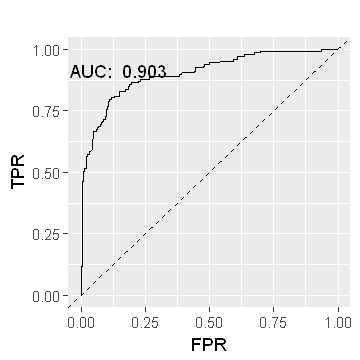

In [49]:
setPlotDim(3, 3)
pred <- prediction(pred.prob, y.test)
plotRoc(pred)

## Perform grid search

In [50]:
runKFoldTuneGrid <- function(x, y, train.control, tune.grid, method = 'glmnet') {
    # Use same seed
    set.seed(123)    
    # Create classifier
    clf <- train(x = x,
                 y = y, 
                 method = method,
                 trControl = train.control,
                 tuneGrid = tune.grid,
                 )
    return(clf)
}

### Set up parameter grid and control

In [51]:
lambda.seq <- log(seq(1, 100, length.out = 100))
tune.grid <- expand.grid(lambda = lambda.seq, alpha = 0)
train.control <- trainControl(method="cv", number=10, classProbs = FALSE)

In [52]:
logit.clf <- runKFoldTuneGrid(X.train.logit, y.train, train.control, tune.grid, method = 'glmnet')

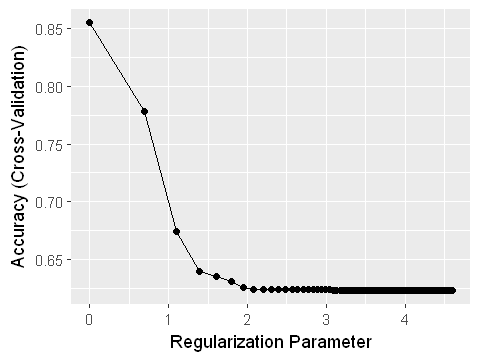

In [53]:
setPlotDim(3, 4)
ggplot(logit.clf)

## Need to narrow down the lambda range

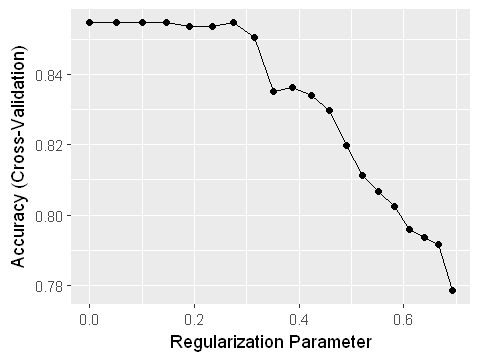

In [54]:
lambda.seq <- log(seq(1, 2, length.out = 20))

tune.grid <- expand.grid(lambda = lambda.seq, alpha = 0)
logit.tune <- runKFoldTuneGrid(X.train.logit, y.train, train.control, tune.grid, method = 'glmnet')
ggplot(logit.tune)

In [55]:
print(logit.tune, showSD=T)

glmnet 

916 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 825, 825, 823, 824, 824, 824, ... 
Resampling results across tuning parameters (values above are 'mean (sd)'):

  lambda      Accuracy                Kappa                 
  0.00000000  0.8548096 (0.02403876)  0.6854876 (0.05572089)
  0.05129329  0.8548096 (0.02403876)  0.6854876 (0.05572089)
  0.10008346  0.8548096 (0.02403876)  0.6854876 (0.05572089)
  0.14660347  0.8548096 (0.02403876)  0.6854876 (0.05572089)
  0.19105524  0.8537343 (0.02556536)  0.6828447 (0.05985137)
  0.23361485  0.8537343 (0.02556536)  0.6828447 (0.05985137)
  0.27443685  0.8547857 (0.03095207)  0.6837845 (0.07094420)
  0.31365756  0.8504256 (0.03178197)  0.6711587 (0.07415672)
  0.35139789  0.8352309 (0.03808102)  0.6320135 (0.09496536)
  0.38776553  0.8363417 (0.04049758)  0.6306741 (0.09884919)
  0.42285685  0.8341320 (0.04024837)  0.6237777 (0.09925235)
  0.45675840  0

## View best tune parameters

In [56]:
## Best tune parameters
coef(logit.tune$finalModel, logit.tune$bestTune$lambda)

8 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  1.02541081
Pclass.2    -0.07225897
Pclass.3    -0.49064353
Age         -0.10732215
Sex.male    -1.78901243
Fare         0.18758986
Embarked.Q  -0.03923292
Embarked.S  -0.21469416

Below we see the predictions that our best model made. The columns are x=0 and x=1, and are P( x | w, x).

In [57]:
pred.best <- predict(logit.tune, X.test.logit, type = 'prob')
head(pred.best)

0,1
0.8328832,0.1671168
0.7975319,0.2024681
0.3661208,0.6338792
0.8147582,0.1852418
0.8256830,0.1743170
0.7463814,0.2536186


In [58]:
print(class(y.test))
print(class(pred.best[, '1']))

[1] "factor"
[1] "numeric"


In [59]:
# Calculate the confusion matrix
cm <- confusionMatrix(y.test, ifelse(pred.best[, '1'] > 0.5, 1, 0), positive = '1')              
cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 214  30
         1  29 118
                                          
               Accuracy : 0.8491          
                 95% CI : (0.8097, 0.8831)
    No Information Rate : 0.6215          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6789          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.7973          
            Specificity : 0.8807          
         Pos Pred Value : 0.8027          
         Neg Pred Value : 0.8770          
             Prevalence : 0.3785          
         Detection Rate : 0.3018          
   Detection Prevalence : 0.3760          
      Balanced Accuracy : 0.8390          
                                          
       'Positive' Class : 1               
                                          

In [60]:
cm$byClass

Sensitivity          Specificity       Pos Pred Value 
           0.7972973            0.8806584            0.8027211 
      Neg Pred Value            Precision               Recall 
           0.8770492            0.8027211            0.7972973 
                  F1           Prevalence       Detection Rate 
           0.8000000            0.3785166            0.3017903 
Detection Prevalence    Balanced Accuracy 
           0.3759591            0.8389779

In [61]:
pred <- prediction(pred.best[, '1'], y.test)

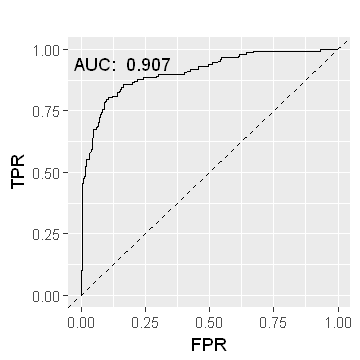

In [62]:
setPlotDim(3, 3)
plotRoc(pred)

## Decision tree (rpart lib.)

In [63]:
library(rpart)
library(rpart.plot)

In [64]:
# Use the split variable to create ned training and test sets
train.set <- dat[split, ]
test.set <- dat[-split, ]

In [65]:
# Just to check
dim(test.set)

[1] 391   6

In [66]:
head(X.train)

,Pclass,Age,Sex,Fare,Embarked
1,3,-0.5800386,male,-0.5016466,S
2,1,0.6620439,female,0.7357413,C
3,3,-0.2695180,female,-0.4886028,S
4,1,0.4291534,female,0.3843648,S
7,1,1.9041264,male,0.3604512,S
8,3,-2.1326418,male,-0.2344905,S


### Run rpart using the regular way

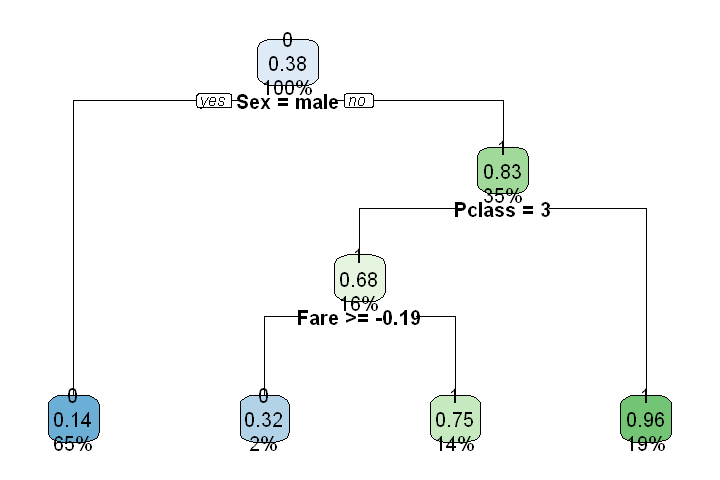

In [67]:
single.tree <- rpart(Survived~., data = train.set, method = 'class')
setPlotDim(4, 6)
rpart.plot(single.tree)

In [68]:
## Here one can see which cp values have been tested out
single.tree$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.6115942,0,1.0000000,1.0000000,0.04250703
2,0.0115942,1,0.3884058,0.3884058,0.03100195
3,0.0100000,3,0.3652174,0.3942029,0.03119248


### Note to self: 

If you want to use different parameters using the rpart function, use the control parameters such as:

```r
single.tree <- rpart(Survived~., data = train.set, method = 'class', control = rpart.control(cp = 0.1))
```

For more info, check ?rpart and ?rpart.control :).

In [69]:
# Predict using the single tre
pred.single.tree <- predict(single.tree, test.set, type = 'prob')
confusionMatrix(test.set$Survived, ifelse(pred.single.tree[, '1'] > 0.5, 1, 0), positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 225  19
         1  30 117
                                          
               Accuracy : 0.8747          
                 95% CI : (0.8377, 0.9058)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7289          
 Mcnemar's Test P-Value : 0.1531          
                                          
            Sensitivity : 0.8603          
            Specificity : 0.8824          
         Pos Pred Value : 0.7959          
         Neg Pred Value : 0.9221          
             Prevalence : 0.3478          
         Detection Rate : 0.2992          
   Detection Prevalence : 0.3760          
      Balanced Accuracy : 0.8713          
                                          
       'Positive' Class : 1               
                                          

### rpart using caret library :)

In [70]:
# Set up parameters
tree.grid <- expand.grid(cp = log(seq(1, 2, length.out = 20)))
tree.control <- trainControl(method = 'cv', number = 10)


# Train the tree model. Test out different parameters
set.seed(123)
tree.tune <- train (x = X.train, y = y.train, method = "rpart", trControl = tree.control, tuneGrid = tree.grid)
print(tree.tune, showSD=T)               

CART 

916 samples
  5 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 825, 825, 823, 824, 824, 824, ... 
Resampling results across tuning parameters (values above are 'mean (sd)'):

  cp          Accuracy                Kappa                 
  0.00000000  0.8373102 (0.04111850)  0.6464046 (0.09625110)
  0.05129329  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.10008346  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.14660347  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.19105524  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.23361485  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.27443685  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.31365756  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.35139789  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.38776553  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.42285685  0.8537107 (0.02821383)  0.6826172 (0.06398019)
  0.45675840  0.8

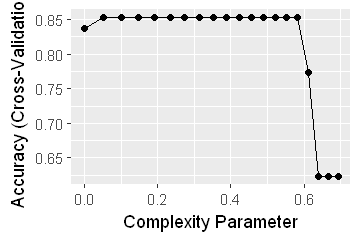

In [71]:
setPlotDim(2, 3)
ggplot(tree.tune)

In [72]:
tree.tune$finalModel

n= 916 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 916 345 0 (0.6233624 0.3766376)  
  2) Sex=male 599  81 0 (0.8647746 0.1352254) *
  3) Sex=female 317  53 1 (0.1671924 0.8328076) *

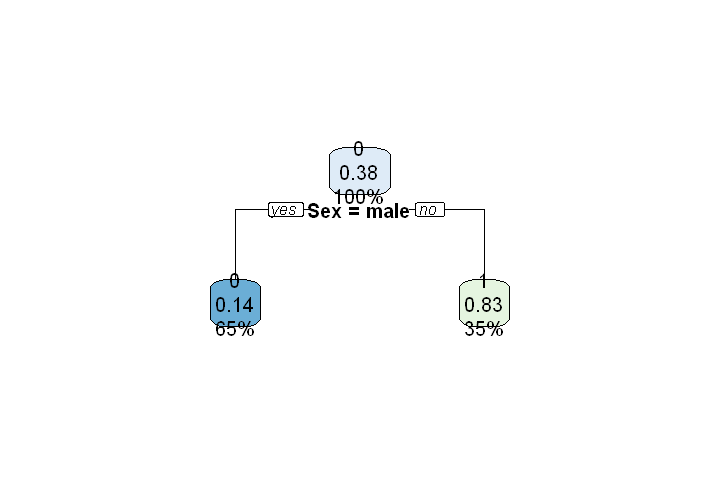

In [73]:
setPlotDim(4, 6)
rpart.plot(tree.tune$finalModel)

In [74]:
pred.best.tree <- predict(tree.tune$finalModel, test.set, type = 'prob')
confusionMatrix(test.set$Survived, ifelse(pred.best.tree[, '1'] > 0.5, 1, 0), positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 216  28
         1  28 119
                                        
               Accuracy : 0.8568        
                 95% CI : (0.8181, 0.89)
    No Information Rate : 0.624         
    P-Value [Acc > NIR] : <2e-16        
                                        
                  Kappa : 0.6948        
 Mcnemar's Test P-Value : 1             
                                        
            Sensitivity : 0.8095        
            Specificity : 0.8852        
         Pos Pred Value : 0.8095        
         Neg Pred Value : 0.8852        
             Prevalence : 0.3760        
         Detection Rate : 0.3043        
   Detection Prevalence : 0.3760        
      Balanced Accuracy : 0.8474        
                                        
       'Positive' Class : 1             
                                        

In [75]:
install.packages('reshape')
library(reshape)

Installing package into 'C:/Users/emirl/Documents/R/win-library/3.3'
(as 'lib' is unspecified)


package 'reshape' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\emirl\AppData\Local\Temp\Rtmp29gKkf\downloaded_packages


Warning message:
"package 'reshape' was built under R version 3.3.3"
Attaching package: 'reshape'

The following object is masked from 'package:Matrix':

    expand

The following object is masked from 'package:dplyr':

    rename



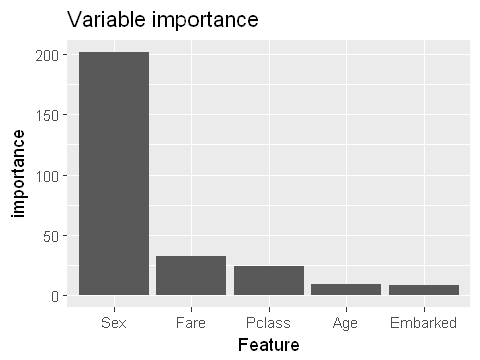

In [76]:
vImp <- as.data.frame(varImp(tree.tune$finalModel))

# Sort the index in order to sort the data frame
index <- with(vImp, order(Overall))

# Create a sorted data frame
sortImp <- data.frame(importance=vImp[index, ], feature=rownames(vImp)[index])

# Plot the variable importance
setPlotDim(3, 4)
ggplot(data=sortImp, aes(x=reorder(feature, -importance), y=importance)) + geom_bar(stat="identity") + labs(x='Feature', title='Variable importance')

## Random Forest

In [77]:
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine



In [78]:
rf.control <- trainControl(method = 'cv', number = 10)
rf.grid <- expand.grid(mtry = seq(1, ncol(train.set) - 1, by = 1))

rf.tune <- train(Survived~., data = train.set, method = 'rf', trControl = rf.control, tuneGrid = rf.grid)

print(rf.tune, showSD=T)

Random Forest 

916 samples
  5 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 825, 825, 825, 824, 824, 825, ... 
Resampling results across tuning parameters (values above are 'mean (sd)'):

  mtry  Accuracy                Kappa                 
  1     0.8024009 (0.03193248)  0.5391412 (0.07890771)
  2     0.8602246 (0.03219293)  0.6962180 (0.06663026)
  3     0.8613115 (0.03191006)  0.6992472 (0.06517003)
  4     0.8493072 (0.03379821)  0.6750967 (0.06958485)
  5     0.8438366 (0.03352857)  0.6644460 (0.06845500)

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 3. 


# Compare models

Let us compare the models in a more compact way.


In [79]:
# Collect resamples
results <- resamples(list(LOGREG=logit.tune, TREE=tree.tune, RandFor=rf.tune))
# summarize the distributions
summary(results)


Call:
summary.resamples(object = results)

Models: LOGREG, TREE, RandFor 
Number of resamples: 10 

Accuracy 
          Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
LOGREG  0.8242  0.8393 0.8516 0.8548  0.8668 0.9022    0
TREE    0.8132  0.8393 0.8470 0.8537  0.8665 0.9130    0
RandFor 0.8132  0.8393 0.8688 0.8613  0.8883 0.9022    0

Kappa 
          Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
LOGREG  0.6161  0.6470 0.6764 0.6855  0.7238 0.7913    0
TREE    0.5985  0.6470 0.6725 0.6826  0.7195 0.8135    0
RandFor 0.6032  0.6491 0.7158 0.6992  0.7538 0.7835    0


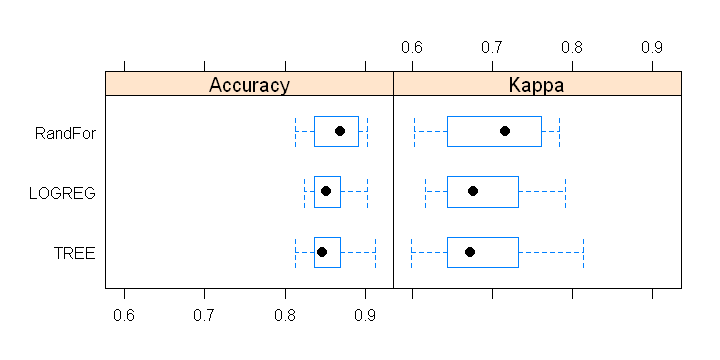

In [80]:
setPlotDim(3, 6)
# boxplots of results
bwplot(results)